In [2]:
# Reading EO results is based on Jim's code here
# https://github.com/lsst-camera-dh/eotest/blob/0dc45fd0e2c11ced3da4714e18c699ef5c1df78f/python/lsst/eotest/sensor/EOTestPlots.py#L285

from astropy.io import fits
import pylab
import re
import glob
import numpy
import traceback
from astropy.stats import mad_std
from lsst.eotest.sensor.EOTestPlots import OverscanTestPlots
%matplotlib inline

In [3]:
ctilimit=3e-6

figsize=(5,5)

def getpctilimit(
    slot="R31_S02",
    runnum=13127
    ):
    
    overscan_file=glob.glob(f"/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/{runnum}/overscan_BOT/v0/*/{slot}_{runnum}_overscan_results.fits")[0]
    plots=OverscanTestPlots(slot,overscan_file,title_addendum=None)

    datasec = plots.header['DATASEC']
    xmin,xmax,ymin,ymax=re.search(r"(\d+):(\d+),(\d+):(\d+)",datasec).groups()
    num_transfers = int(ymax)

    xarr = []
    for amp in plots.all_amps:
        if amp > 8: marker='s'
        else: marker = '^'    
        data = plots.overscan_data[amp]['ROW_MEAN']
        signal = plots.overscan_data[amp]['FLATFIELD_SIGNAL']
        lastpixel = data[:, 0]
        overscan1 = data[:, 1]
        overscan2 = data[:, 2]
        cti = (overscan1+overscan2)/(num_transfers*lastpixel)
        indices = (signal<175000.) &  (signal>5e4)
        pctilimit = signal[indices][numpy.argmin(numpy.fabs(cti[indices]-ctilimit))]
        xarr.append(pctilimit)

    return list(plots.all_amps), xarr


raft_types = {}
raft_types['e2v'] = 'R11 R12 R13 R14 R21 R22 R23 R24 R30 R31 R32 R33 R34'.split()

arr=[]

targets = [
                (13039, 5),
                (13038, 0),
#                (13126, 1),
                (13136, 1),
#                (13125, 2),
                (13135, 2),
                (13127, 3),
                (13128, 4)
                ]

for arun, order in targets:
    res = []
    for araft in raft_types['e2v']:        
        for sensor in '00 01 02 10 11 12 20 21 22'.split():
            try:
                res.append(getpctilimit(f"{araft}_S{sensor}",arun)[1])
            except:
                res.append( [numpy.nan]*16 )
                traceback.print_exc()                

    arr.append(numpy.array(res))



Traceback (most recent call last):
  File "<ipython-input-3-99346b56b88d>", line 55, in <module>
    res.append(getpctilimit(f"{araft}_S{sensor}",arun)[1])
  File "<ipython-input-3-99346b56b88d>", line 28, in getpctilimit
    pctilimit = signal[indices][numpy.argmin(numpy.fabs(cti[indices]-ctilimit))]
  File "<__array_function__ internals>", line 6, in argmin
  File "/gpfs/slac/lsst/fs3/g/software/stack/v21.0.0/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 1269, in argmin
    return _wrapfunc(a, 'argmin', axis=axis, out=out)
  File "/gpfs/slac/lsst/fs3/g/software/stack/v21.0.0/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 58, in _wrapfunc
    return bound(*args, **kwds)
ValueError: attempt to get argmin of an empty sequence
Traceback (most recent call last):
  File "<ipython-input-3-99346b56b88d>", line 55, in <module>
    res.append(getpctilimit(f"{

In [12]:
numpy.nanpercentile(arr,[100-68.27,68.27],axis=(1,2))

array([[140096.3214375 , 127745.51582813, 132788.88490625,
        135749.96674219, 137737.72528125, 139757.58519531],
       [148984.82583594, 137679.40816406, 141989.72990625,
        144980.61484375, 146884.811875  , 148677.93267969]])

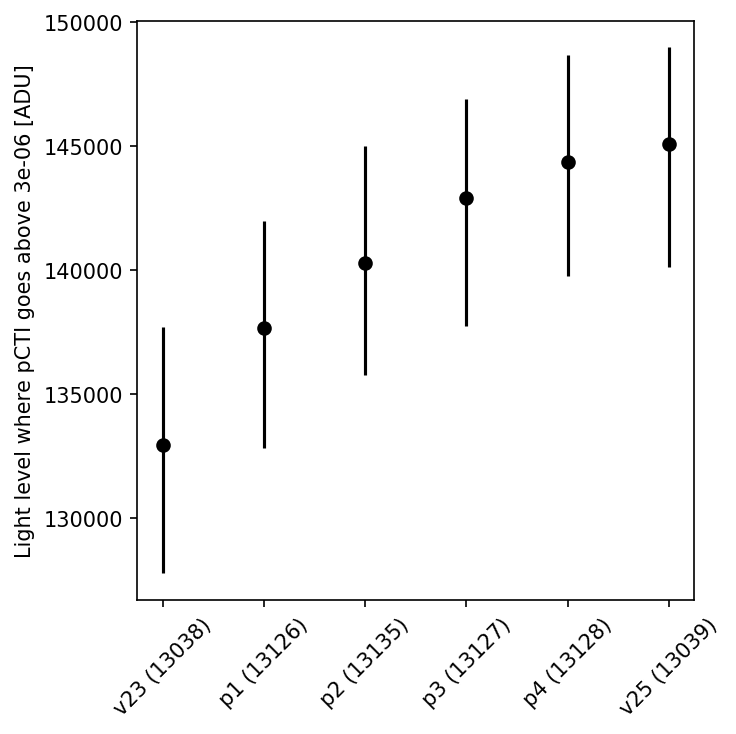

In [21]:
fig, bx = pylab.subplots(1, 1, figsize=figsize, facecolor="white",dpi=150)
#pylab.errorbar([ order[1] for order in targets ], numpy.nanmean(arr,axis=(1,2)), yerr=numpy.nanstd(arr,axis=(1,2)), fmt="o", label="mean, std")
med=numpy.nanmedian(arr,axis=(1,2))
pylab.errorbar([ order[1] for order in targets ], med,
               yerr=numpy.abs(numpy.nanpercentile(arr,[100-68.27,68.27],axis=(1,2))-med),
               fmt="ko")
#pylab.legend()
bx.set_xticklabels(["0","v23 (13038)","p1 (13126)","p2 (13135)","p3 (13127)","p4 (13128)","v25 (13039)"],rotation=45)
#pylab.ylim(90000,180000)
pylab.ylabel(f"Light level where pCTI goes above {ctilimit} [ADU]")
pylab.tight_layout()
pylab.savefig(f"fullwelloptimization.pdf")


Text(0.5, 0, 'Light level where pCTI goes above 3e-06')

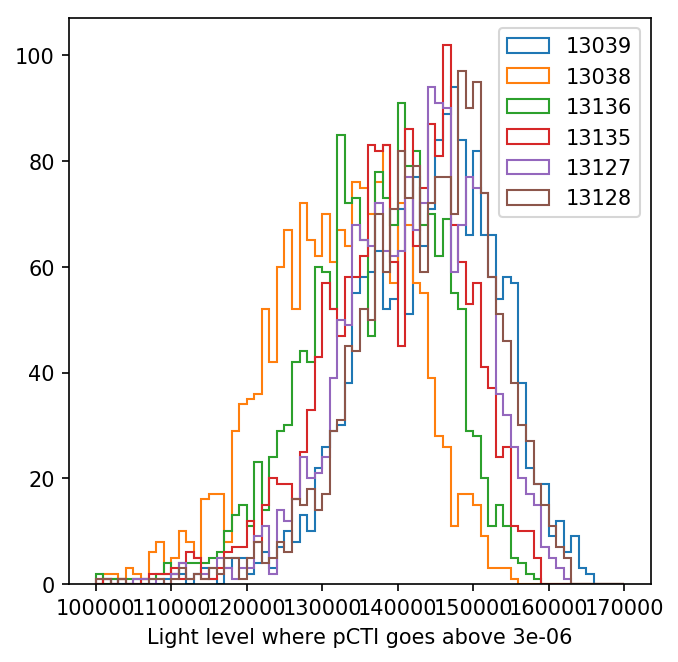

In [5]:
fig, bx = pylab.subplots(1, 1, figsize=figsize, facecolor="white",dpi=150)
for a,target in zip(numpy.array(arr),targets):
    try:
        pylab.hist(a.flatten(),range=(100000,170000),bins=(70),histtype="step",label=target[0])
    except:
        pass
    
pylab.legend()
pylab.xlabel(f"Light level where pCTI goes above {ctilimit}")